In [3]:
import svf
from glob import glob
from echolab2.instruments import EK80
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


#file_dir = 'I:/202400_SimSeq/' # set the input file directory
file_dir = 'I:/DY202403_FMData/fm/SimSeq/' 
raw_files = sorted(glob(file_dir+'Sim/*.raw'))[-20:-5]
ek80 = EK80.EK80()
ek80.read_raw(raw_files)
svf_results = svf.svf()
frequencies = [38000,70000,120000,200000]
for freq in frequencies:
    inputs = svf.inputs(ek80,freq,add_cw=False,frequency_resolution=None)
    svf_results.calc_sample_Svf(inputs,exclude_above_line=5,exclude_below_line=60) 
    #svf_results.grid_Svf(inputs,interval_length=10, layer_thickness=2.5)
    #svf_results.get_noise(inputs)
resSim = svf_results

raw_files = sorted(glob(file_dir+'Seq/*.raw'))[-20:-5]
ek80 = EK80.EK80()
ek80.read_raw(raw_files)
svf_results = svf.svf()
frequencies = [38000,70000,120000,200000]
for freq in frequencies:
    inputs = svf.inputs(ek80,freq,add_cw=False,frequency_resolution=None)
    svf_results.calc_sample_Svf(inputs,exclude_above_line=5,exclude_below_line=60) 
    svf_results.grid_Svf(inputs,interval_length=10, layer_thickness=2.5)
    svf_results.get_noise(inputs)
resSeq = svf_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IndexError: list index out of range

In [283]:
import numpy as np
def nearest_ind(items, pivot):
    time_diff = np.abs([date - pivot for date in items])
    return time_diff.argmin(0)

r = 5
redges = np.arange(12.5,60,r)
full_sim = {}
full_seq = {}

for f in [38000,70000,120000,200000]:
    grid_sim = []
    grid_seq = []
    l = np.arange(len(resSeq.ping_time[f]))
    n = 10
    x = [l[i:i + n] for i in range(0, len(l), n)]  
    for pseq in x:
        #self.calc_noise(iter_interval)
        hold_layer_sim = []
        hold_layer_seq = []
        psim = nearest_ind(resSim.ping_time[f],resSeq.ping_time[f][pseq])
        for rsub in redges:
            rIdx = np.where((resSeq.svf_range[f]>=rsub)&(resSeq.svf_range[f]<rsub+r))[0]
            hold_layer_sim.append((svf.pMean(svf.pMean(svf.pMean(resSim.Sv_sample[f][psim])[rIdx]))))
            hold_layer_seq.append((svf.pMean(svf.pMean(svf.pMean(resSeq.Sv_sample[f][pseq])[rIdx]))))
        grid_sim.append(np.array(hold_layer_sim))
        grid_seq.append(np.array(hold_layer_seq))
    full_sim[f] = np.array(grid_sim)
    full_seq[f] = np.array(grid_seq)

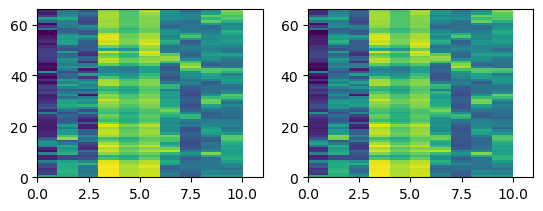

In [249]:
import matplotlib.pyplot as plt
f = 200000
plt.subplot(221)
plt.pcolor(full_sim[f])
plt.subplot(222)
plt.pcolor(full_seq[f])

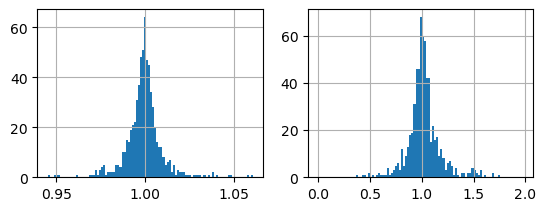

In [250]:
import matplotlib.pyplot as plt
plt.subplot(221)
plt.hist(np.ravel(full_sim[f])/np.ravel(full_seq[f]),bins=100);
plt.grid()
plt.subplot(222)
plt.hist((10**((np.ravel(full_sim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(full_seq[f])/10))*r*4*np.pi*(1852**2)),bins=np.arange(0,2,.02));
plt.grid()

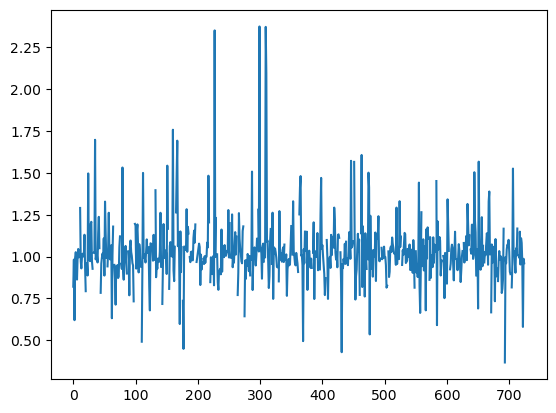

In [260]:
plt.plot(((10**((np.ravel(full_sim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(full_seq[f])/10))*r*4*np.pi*(1852**2))))

In [85]:
mean = np.log10(np.nanmean(10**((10**((np.ravel(full_sim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(full_seq[f])/10))*r*4*np.pi*(1852**2)))))

std = np.nanstd((10**((np.ravel(full_sim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(full_seq[f])/10))*r*4*np.pi*(1852**2)))
se = (std/len(np.ravel(full_sim[f])))*1.96

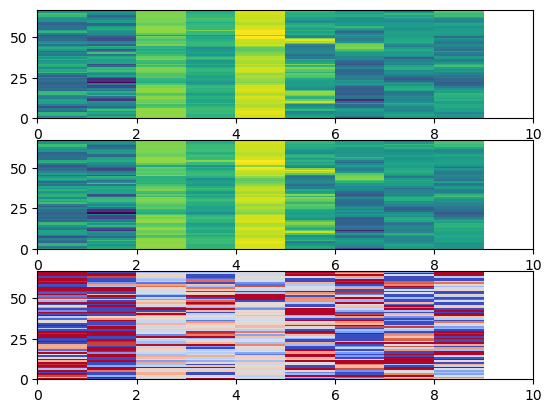

In [284]:
import matplotlib.pyplot as plt
f = 38000
plt.subplot(311)
plt.pcolor(full_sim[f])
plt.subplot(312)
plt.pcolor(full_seq[f])
plt.subplot(313)
plt.pcolor((10**(((full_sim[f])/10))*r*4*np.pi*(1852**2))/(10**(((full_seq[f])/10))*r*4*np.pi*(1852**2)),vmin=.95,vmax=1.05,cmap='coolwarm')

In [273]:
fsim  = full_sim
fseq = full_seq
for f in [38000,70000,120000,200000]:
    
    fsim[f][fsim[f]<-70]=np.nan
    fseq[f][fseq[f]<-70]=np.nan
    b = []
    for i in range(5000):
        b.append(np.log(np.nanmean(np.exp(np.random.choice((10**((np.ravel(fsim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(fseq[f])/10))*r*4*np.pi*(1852**2)),size=len(np.ravel(fsim[f])),replace=True)))))
    print(f)
    print('mean:',np.log10(np.nanmean(10**((10**((np.ravel(fsim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(fseq[f])/10))*r*4*np.pi*(1852**2))))))
    print('low:',np.percentile(b,2.5))
    print('high:',np.percentile(b,97.5))

38000
mean: 1.0076664715173453
low: 0.9954052458523609
high: 1.0167379105938836
70000
mean: 0.9248365272894141
low: 0.9099108460012656
high: 0.9333289319937219
120000
mean: 1.036915630369675
low: 1.012315946896859
high: 1.0461271312297853
200000
mean: 1.0239405459404591
low: 1.0034387028548397
high: 1.0347242115139146


There are tow things going wrong here:
1) there is not a consistent ratio being produced between the two datasets
2) there is probably a noise floor isue in the dataset and I'm not sure what the clean thing to do is

fd

660

38000 0.9987476996954273 0.9913448023695116 1.006150597021343
70000 0.9982361357716453 0.985409493178803 1.0110627783644877
120000 1.0138488286523202 0.9913495766907383 1.036348080613902
200000 1.0153998852513149 1.0036657306152499 1.0271340398873798


Text(0, 0.5, 's$_{A,sim}$/s$_{A,seq}$')

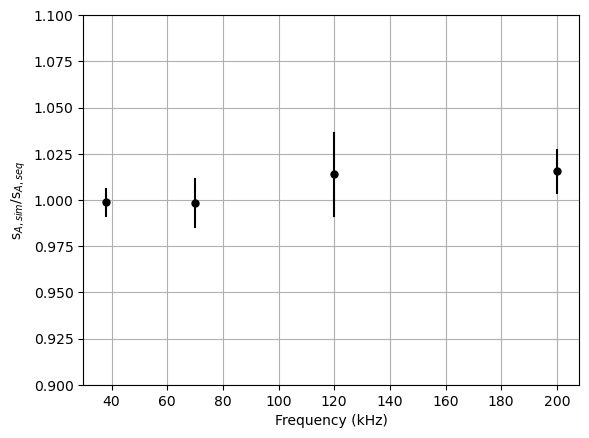

In [304]:
for f in [38000,70000,120000,200000]:
    cursimsa =  10**(full_sim[f]/10)*r*4*np.pi*(1852**2)
    curseqsa = 10**(full_seq[f]/10)*r*4*np.pi*(1852**2)
    mean = 10**(np.nanmean(np.log10(cursimsa/curseqsa)))
    std = np.nanstd(cursimsa/curseqsa)
    se = std/np.sqrt(len(np.ravel(full_seq[f])))
    print(f,mean,mean-(se*1.96),mean+(se*1.96))
    plt.plot(f/1000,mean,'.k',markersize=10)
    plt.plot([f/1000,f/1000],[mean-(se*1.96),mean+(se*1.96)],'k')
plt.grid()
plt.ylim(.9,1.1)
plt.xlabel('Frequency (kHz)')
plt.ylabel('s$_{A,sim}$/s$_{A,seq}$')

38000 0.9987476996954273 0.9913448023695116 1.006150597021343
70000 0.9982361357716453 0.985409493178803 1.0110627783644877
120000 1.0138488286523202 0.9913495766907383 1.036348080613902
200000 1.0181698723607853 1.0037432393290555 1.032596505392515


Text(0, 0.5, 's$_{A,sim}$/s$_{A,seq}$')

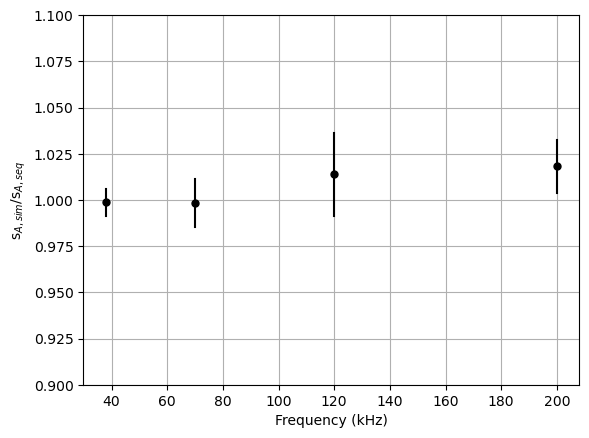

In [286]:
for f in [38000,70000,120000,200000]:
    cursimsa =  10**(full_sim[f]/10)*r*4*np.pi*(1852**2)
    curseqsa = 10**(full_seq[f]/10)*r*4*np.pi*(1852**2)
    mean = 10**(np.nanmean(np.log10(cursimsa/curseqsa)))
    std = np.nanstd(cursimsa/curseqsa)
    se = std/np.sqrt(len(np.ravel(full_seq[f])))
    print(f,mean,mean-(se*1.96),mean+(se*1.96))
    plt.plot(f/1000,mean,'.k',markersize=10)
    plt.plot([f/1000,f/1000],[mean-(se*1.96),mean+(se*1.96)],'k')
plt.grid()
plt.ylim(.9,1.1)
plt.xlabel('Frequency (kHz)')
plt.ylabel('s$_{A,sim}$/s$_{A,seq}$')

In [291]:
np.log10(np.nanmean(10**(np.array(b))))

1.0551477547999186

In [293]:
fsim  = full_sim
fseq = full_seq

In [294]:
fsim[f][fsim[f]<-70]=np.nan
fseq[f][fseq[f]<-70]=np.nan
for f in [38000,70000,120000,200000]:
    b = []
    for i in range(5000):
        b.append(np.log(np.nanmean(np.exp(np.random.choice((10**((np.ravel(fsim[f])/10))*r*4*np.pi*(1852**2))/(10**((np.ravel(fseq[f])/10))*r*4*np.pi*(1852**2)),size=len(np.ravel(fsim[f])),replace=True)))))
    print(f)
    print('mean:',np.log10(np.nanmean(10**((np.array(b))))))
    print('low:',np.percentile(b,2.5))
    print('high:',np.percentile(b,97.5))

38000
mean: 1.0082628903958957
low: 0.9995694166826078
high: 1.0172512876783655
70000
mean: 1.0255957421329076
low: 1.0075960870480276
high: 1.0455383382499055
120000
mean: 1.213909171288523
low: 1.043347054230451
high: 1.4453550723419464
200000
mean: 1.0401801573549265
low: 1.0192161859701399
high: 1.0652183439119627
